In my [previous]({{< ref "/blog/time-series-for-scikit-learn-people-part1" >}}) [posts]({{< ref "/blog/time-series-for-scikit-learn-people-part2" >}}) in the "time series for scikit-learn people" series, I discussed how one can train a machine learning model to _predict_ the next element in a time series. Often, one may want to predict the value of the time series further in the future. In those posts, I gave two methods to accomplish this. One method is to train the machine learning model to specifically predict that point in the future. This method is poor because, if one would like to know the value of the time series at two different points in the future, then they are again out of luck.

The other method is recursive forecasting. This is accomplished by feeding in the prediction of the model as a new input and using this to predict a new output. One iterates this, "rolling" the predictions forward until the future point of interest is reached. In python, this would look like

In [1]:
def recursive_forecast(model, input_data, num_points_in_future):
    for point in range(num_points_in_future):
        prediction = model.predict(input_data)
        # Append prediction to the input data
        input_data = np.hstack((input_data, prediction))
        
    return prediction

From a machine learning viewpoint, this form of forecasting is bizarre. You could train a model that has excellent test error on predicting the next step in a time series but then fails spectacularly to forecast multiple values in the time series. If your true objective is to minimize error on predicting multiple future values in a time series, then you ought to construct a loss function that directly minimizes this error! In this blog post I will show you a couple different ways to do this so-called direct forecasting using my library [skits](https://github.com/ethanrosenthal/skits). Along the way, we will have some fun moving up the chain of model complexity, from `scikit-learn` linear models, to [XGBoost](https://xgboost.readthedocs.io/en/latest/), to deep learning models in [PyTorch](https://pytorch.org/). And of course, everything will be compatible with the `scikit-learn` API.

_Note: While recursive forecasts may seem crazy from a machine learning standpoint, there are many solid reasons to use them, and the question of whether to use recursive or direct forecasts is fairly nuanced. [Souhaib Ben Taieb's](http://souhaib-bentaieb.com) PhD [thesis (pdf)](http://souhaib-bentaieb.com) has a good discussion with references._

## When in doubt, use more models

If compute and memory and time are cheap, then you can brute force a forecast by training a separate model for each point in the future that you want to predict. For example, if you have a time series with a sample every minute (aka a sampling frequency of 1/60 Hz) and you would like to forecast every point in the next hour, then you would train 60 different models. Each model would have a different point in the future as its "target" (or `y` in `scikit-learn` parlance), and you would generate a full hour forecast by calculating the prediction of each model.

The nice thing about this method is that you can use any regression model you want that predicts a single target. And in fact, it turns out that `scikit-learn` has a class that allows you to do this. All you have to do is wrap your model estimator with the `MultiOutputRegressor` class. Once wrapped, then `scikit-learn` will train an individual estimator for each column in your `y` matrix. Thus, all we need to do is transform our time series `y` such that it turns from an array into a matrix where each column is a step forward in the future. The `HorizonTransformer` in `skits` does just this. For a `horizon` of `3`, a time series goes from

In [2]:
import numpy as np

y = np.arange(10, dtype=np.float32)
y

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)

to

In [3]:
from skits.preprocessing import HorizonTransformer
ht = HorizonTransformer(horizon=3)
y_horizon = ht.fit_transform(y.reshape(-1, 1))
y_horizon

array([[ 0.,  1.,  2.],
       [ 1.,  2.,  3.],
       [ 2.,  3.,  4.],
       [ 3.,  4.,  5.],
       [ 4.,  5.,  6.],
       [ 5.,  6.,  7.],
       [ 6.,  7.,  8.],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]], dtype=float32)

Note that the `HorizonTransformer` maintains the length of the `y` array, so we end up with `NaN` values for the last 3 rows.

## Start Simple: Linear Models

Let's now try training a linear regression model to predict the next 2 hours of data on our good ol' Citibike dataset that I have been using throughout this series. [Recall]({{< ref "/blog/time-series-for-scikit-learn-people-part1" >}}) that the data consists of the number of bikes that were available at the Citibike station near my apartment. The points in the time series are spaced apart by 5 minutes. Thus, if we want to predict the next 2 hours of data, then we will need to predict the next 24 points in the time series.

In [4]:
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.ion()

In [5]:
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [6]:
import pickle

with open('station_496_availability.pkl', 'rb') as f:
    y = pickle.load(f)

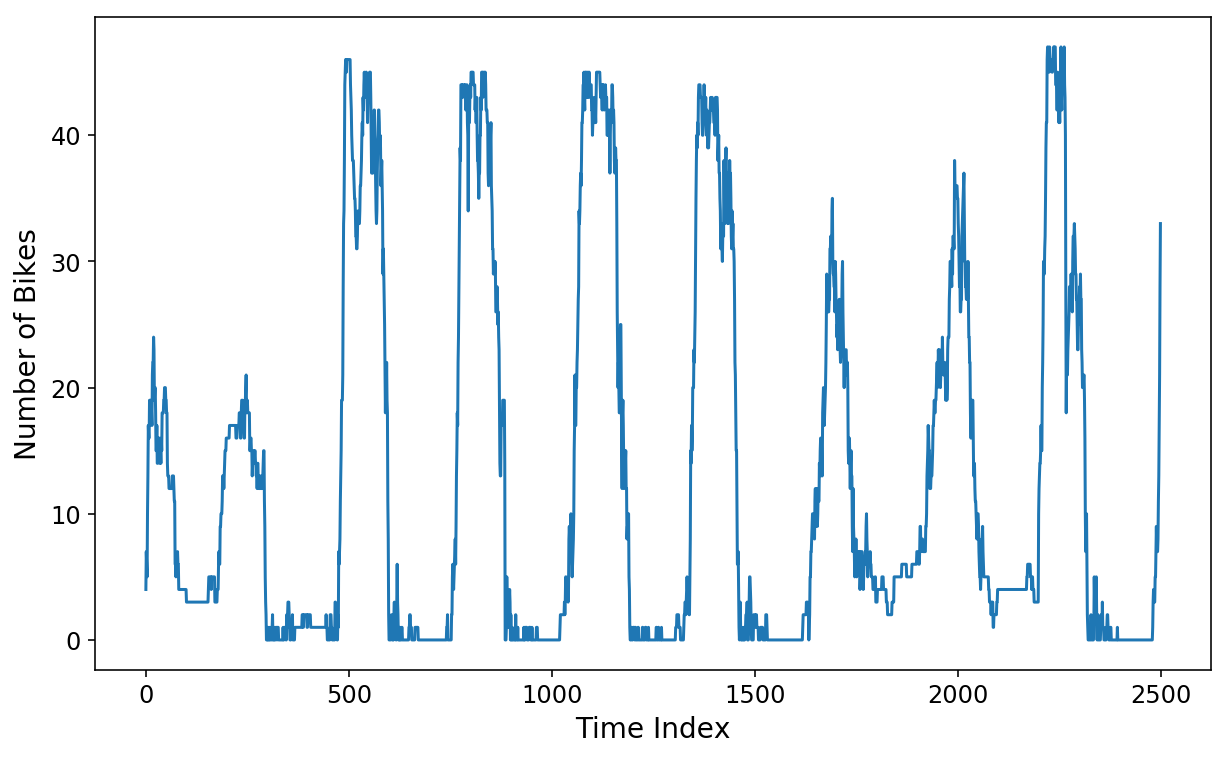

In [7]:
plt.plot(y[:2500]);
plt.xlabel('Time Index');
plt.ylabel('Number of Bikes');

We'll use `skits` to construct a design matrix consisting of the previous _week's_ worth of data. This is definitely overkill, but I will want to throw a lot of features at the more complex models that we'll build later on.

In [8]:
period_minutes = 5
samples_per_hour = int(60 / period_minutes)
samples_per_day = int(24 * samples_per_hour)
samples_per_week = int(7 * samples_per_day)
print(f'Number of "features": {samples_per_week}')

Number of "features": 2016


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import FeatureUnion

from skits.feature_extraction import AutoregressiveTransformer
from skits.pipeline import ForecasterPipeline
from skits.preprocessing import ReversibleImputer

lin_pipeline = ForecasterPipeline([
    # Convert the `y` target into a horizon
    ('pre_horizon', HorizonTransformer(horizon=samples_per_hour * 2)),
    ('pre_reversible_imputer', ReversibleImputer(y_only=True)),
    ('features', FeatureUnion([
        # Generate a week's worth of autoregressive features
        ('ar_features', AutoregressiveTransformer(num_lags=samples_per_week)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', MultiOutputRegressor(LinearRegression(fit_intercept=False),
                                       n_jobs=6))
])

We now have a `pipeline` that will generate a week's worth of autoregressive features and fit a `LinearRegression` model for each of the 24 points in the 2-hour horizon that we would like to predict. We'll reserve 1000 points at the end of the time series as our "test" data, although this is not meant to represent a true train/test/cross validation procedure.

In [10]:
X = y.reshape(-1, 1).copy()

test_size = 1000
train_size = len(X) - test_size
lin_pipeline = lin_pipeline.fit(X[:train_size], y[:train_size])

## Prediction Inspection

With the fitted pipeline, we can now generate horizon predictions. Calling `predict` on the pipeline will now generate a 2-hour, 24 data point prediction at each point in the data `X`. Passing in `start_idx` will return predictions starting at the `start_idx` of X (which in our case will be the start of the test data). 

`prediction` will have 24 columns where the first column represents the first data point in the future (in our case, 5 minutes in the future) all the way up to the 24th data point in the future.

In [12]:
lin_prediction = lin_pipeline.predict(X, start_idx=train_size)
print(f'X shape: {X.shape}')
print(f'prediction shape: {lin_prediction.shape}')

X shape: (74389, 1)
prediction shape: (1000, 24)


There are a couple different ways that we can now inspect our prediction. To start, we can plot a single, 2-hour prediction against the ground truth test data.

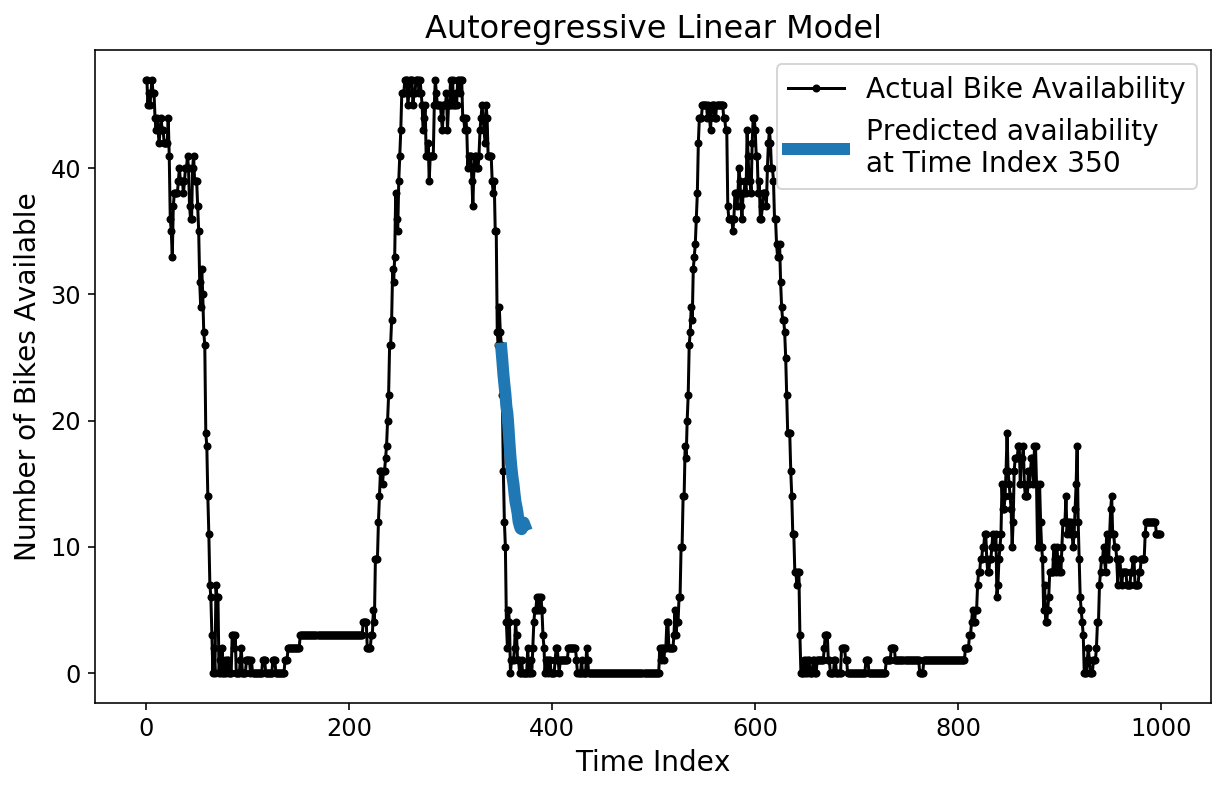

In [13]:
plt.figure();
plt.plot(y[-test_size:], 'k.-');
plt.plot(np.arange(350, 374), lin_prediction[350, :], linewidth=6);
plt.ylabel('Number of Bikes Available');
plt.xlabel('Time Index');
plt.title('Autoregressive Linear Model');
plt.legend(['Actual Bike Availability', 
            'Predicted availability \nat Time Index 350']);

We can also layer on different horizon predictions to see how they compare to each other. Below, I plot the true bike availability, the 1-hour prediction, and the 2-hour prediction. The 1-hour prediction corresponds to what our model would predict for the bike availability at a particular time, given all of the data up until an hour prior to that time. 

Surpisingly to me, both the 1-hour and 2-hour predictions look pretty good by eye! You can see that the 2-hour prediction is slightly more "off" from the Actual data compared to the 1-hour prediction, which makes sense.

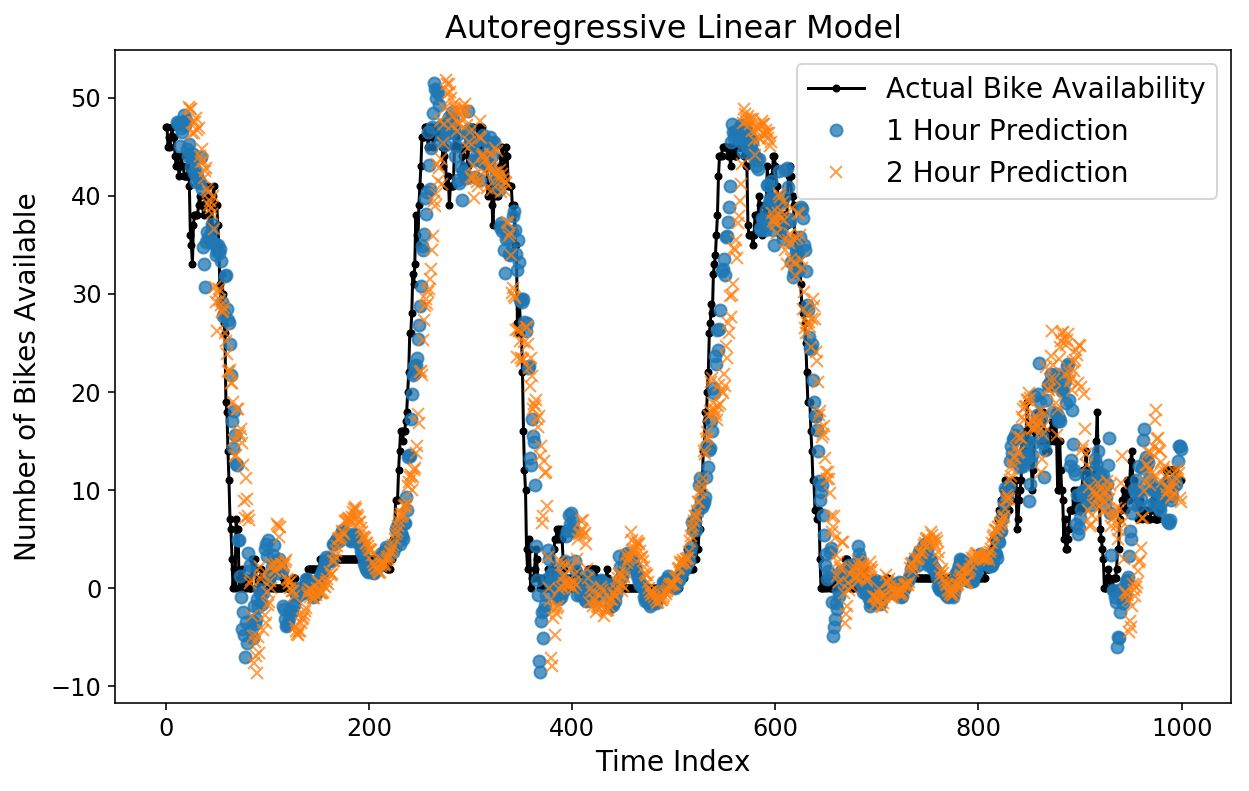

In [14]:
plt.figure();
plt.plot(y[-test_size:], 'k.-');
plt.plot(np.arange(11, test_size),  lin_prediction[:-11, 11], 'o', alpha=0.75);
plt.plot(np.arange(23, test_size), lin_prediction[:-23, 23], 'x', alpha=0.75);
plt.legend(['Actual Bike Availability', 
            '1 Hour Prediction', 
            '2 Hour Prediction']);
plt.ylabel('Number of Bikes Available');
plt.xlabel('Time Index');
plt.title('Autoregressive Linear Model');

Staring at graphs is helpful for intuition but not particularly rigorous in terms of evaluating true performance. We can employ a simple performance metric and calculate the mean absolute error (MAE) as a function of each point in the future that we are trying to estimate. Thankfully, `scikit-learn` has built-in functions that handle this for 2D `y` data.

By the way, why mean absolute error? For something like bike availability, it feels natural to want to be able to answer the question "How many bikes off might we be when we predict the bike availability in 1 hour?"

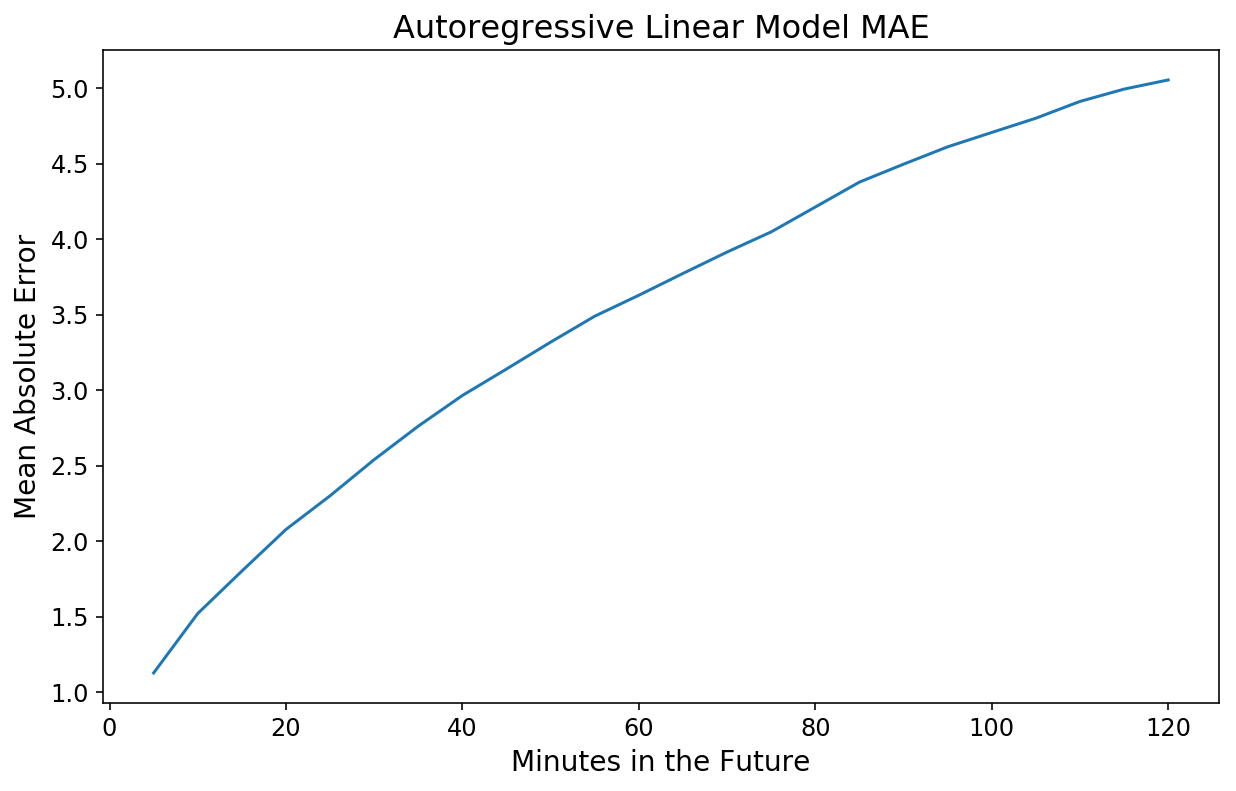

In [16]:
from sklearn.metrics import mean_absolute_error

y_actual = lin_pipeline.transform_y(X)
lin_mae = mean_absolute_error(y_actual[-test_size:], lin_prediction,
                              multioutput='raw_values')
plt.plot(np.arange(1, 25) * 5, lin_mae);
plt.xlabel('Minutes in the Future');
plt.ylabel('Mean Absolute Error');
plt.title('Autoregressive Linear Model MAE');

Not too shabby! Our 20-minute forecast is off by 2 bikes, on average, and our 2-hour forecast is only off by 5.

While our horizon prediction looks pretty good, we can still try out a recursive prediction by using the `pipeline.forecast` method. We'll generate a recursive forecast, starting at index 530 in the test data.

In [29]:
forecast = lin_pipeline.forecast(X, 
                                 start_idx=train_size + 530, 
                                 trans_window=samples_per_week)

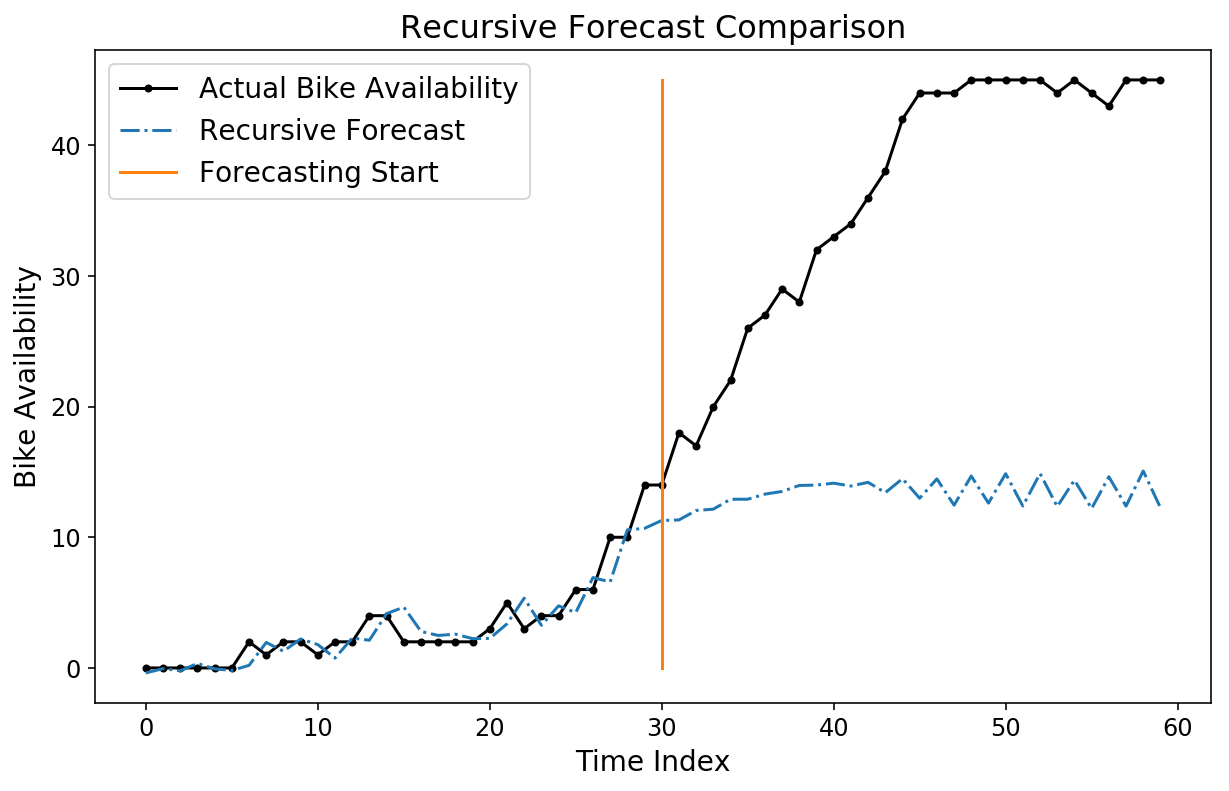

In [40]:
plt.plot(y[-test_size+500:-test_size + 560], 'k.-');
plt.plot(forecast[-test_size+500:-test_size + 560, 0], '-.');
plt.plot((30, 30), (0, 45));
plt.legend(['Actual Bike Availability',
            'Recursive Forecast',
            'Forecasting Start']);
plt.ylabel('Bike Availability');
plt.xlabel('Time Index');
plt.title('Recursive Forecast Comparison');

Notice how our forecast looks pretty bad! To be fair, it's not necessarily clear that we _should_ have a good forecast, seeing as the model was trained to optimize horizon forecasts and _not_ recursive forecasts.

## Boosters

Just because we can, let's try training an XGBoost model for our horizon predictions, rather than a linear regression. I don't believe that it is possible to directly optimize a multioutput regression target with XGBoost, so we will go the same route as with the linear model and train 24 different XGBoost estimators.

In [43]:
from xgboost import XGBRegressor


xgb_pipeline = ForecasterPipeline([
    # Convert the `y` target into a horizon
    ('pre_horizon', HorizonTransformer(horizon=samples_per_hour * 2)),
    ('pre_reversible_imputer', ReversibleImputer(y_only=True)),
    ('features', FeatureUnion([
        # Generate a week's worth of autoregressive features
        ('ar_features', AutoregressiveTransformer(num_lags=samples_per_week)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', MultiOutputRegressor(XGBRegressor(n_jobs=12, 
                                                    n_estimators=300)))
])

xgb_pipeline = xgb_pipeline.fit(X[:train_size], y[:train_size])

In [19]:
xgb_prediction = xgb_pipeline.predict(X, start_idx=train_size)

Let's check out the horizon predictions. By eye, things look better than the linear model, and the MAE plot confirms this.

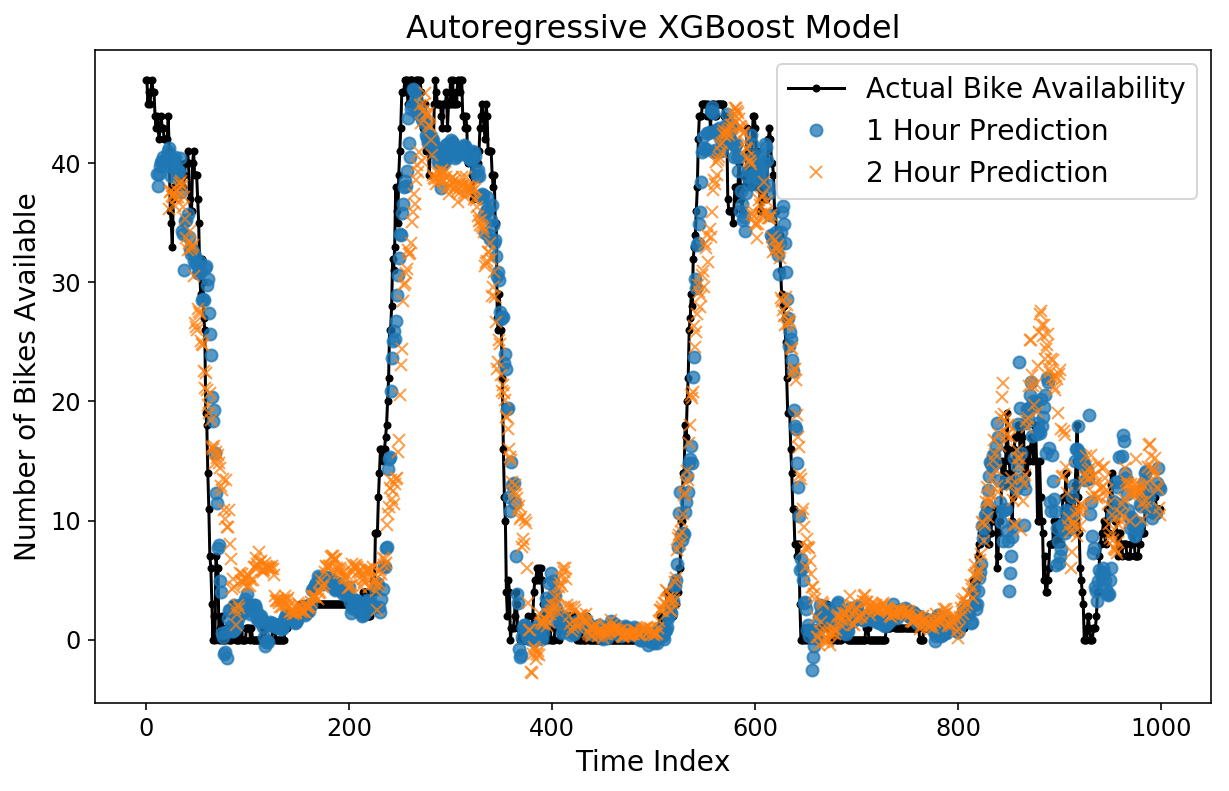

In [20]:
plt.figure();
plt.plot(y[-test_size:], 'k.-');
plt.plot(np.arange(11, test_size),  xgb_prediction[:-11, 11], 'o', alpha=0.75);
plt.plot(np.arange(23, test_size), xgb_prediction[:-23, 23], 'x', alpha=0.75);
plt.legend(['Actual Bike Availability', 
            '1 Hour Prediction', 
            '2 Hour Prediction']);
plt.ylabel('Number of Bikes Available');
plt.xlabel('Time Index');
plt.title('Autoregressive XGBoost Model');

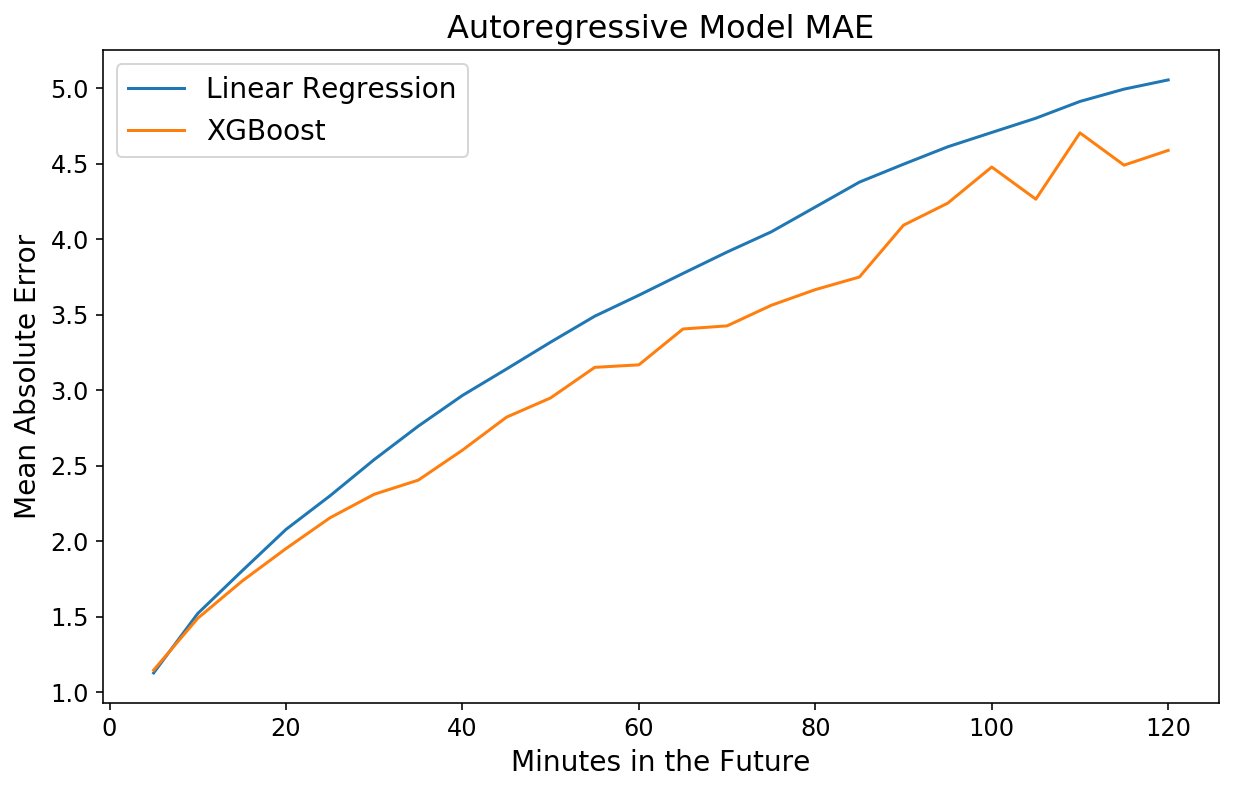

In [22]:
y_actual = xgb_pipeline.transform_y(X)
xgb_mae = mean_absolute_error(y_actual[-test_size:], xgb_prediction,
                              multioutput='raw_values')
plt.plot(np.arange(1, 25) * 5, lin_mae);
plt.plot(np.arange(1, 25) * 5, xgb_mae);
plt.xlabel('Minutes in the Future');
plt.ylabel('Mean Absolute Error');
plt.title('Autoregressive Model MAE');
plt.legend(['Linear Regression', 'XGBoost']);

## Deep Inside

Finally, let's train a deep learning model for horizon prediction. I've written before about how much I love the [skorch](https://github.com/dnouri/skorch) library, and we'll use it again here. By using skorch, we can make any PyTorch model into a scikit-learn estimator. I did some quick Googling on the latest and greatest in sequence modeling with deep learning, and I came across this [paper](https://arxiv.org/abs/1803.01271) that argues that using convolutional neural networks for sequences is actually better and more efficient than recurrent architectures. The authors were kind enough to release a PyTorch implementation of their [code](https://github.com/locuslab/TCN) to go along with the paper, so I am going to reuse their code below for creating "Temproal Convolutional Networks" (TCN).

To be clear, I understand probably 75% of the paper. Below is a diagram (Figure 1 from the paper) of the TCN. I would suggest reading the paper if you are particularly interested.

![/images/horizon-optimization/tcn_fig.png](/images/horizon-optimization/tcn_fig.png)

In [91]:
from sklearn.preprocessing import StandardScaler
from skorch.regressor import NeuralNetRegressor
from skorch.callbacks import GradientNormClipping
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm


"""
Below code in this cell is taken from
https://github.com/locuslab/TCN
"""

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, output_sz, 
                 kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, 
                                     dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, 
                                     dropout=dropout)]

        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_sz)
        self.last_activation = nn.ReLU()
        self.output_sz = output_sz

    def forward(self, x):
        batch_sz = x.shape[0]
        out = self.network(x.unsqueeze(1))
        out = out.transpose(1, 2)
        out = self.linear(out).mean(dim=1)
        
        return out

The paper mentions using default settings of 0.002 learning rate, gradient norm clipping, and making sure that the number of channels captures the full history of the time series. I implement that all below and train for 60 epochs. Notice that we do not have to train 24 different models in this case. Instead, our loss function is simply mean squared error across the full horizon, and PyTorch is able to automatically calculate gradients to train a _single_ model to optmize for the full horizon.

In [ ]:
net = NeuralNetRegressor(
    module=TemporalConvNet,
    module__num_inputs=1,
    module__num_channels=[10] * 11,
    module__output_sz=2 * samples_per_hour,
    module__kernel_size=5,
    module__dropout=0.0,
    max_epochs=60,
    batch_size=256,
    lr=2e-3,
    optimizer=torch.optim.Adam,
    device='cuda',
    iterator_train__shuffle=True,
    callbacks=[GradientNormClipping(gradient_clip_value=1, 
                                    gradient_clip_norm_type=2)],
    train_split=None,
)

dl_pipeline = ForecasterPipeline([
    ('pre_scaler', StandardScaler()),
    ('pre_horizon', HorizonTransformer(horizon=samples_per_hour * 2)),
    ('pre_reversible_imputer', ReversibleImputer(y_only=True)),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=samples_per_week)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', net)
])
dl_pipeline = dl_pipeline.fit(X[:train_size].astype(np.float32), 
                              y[:train_size].astype(np.float32), 
                              end_idx=-5)

In [103]:
dl_prediction = dl_pipeline.predict(X.astype(np.float32), start_idx=train_size,
                                    to_scale=True)

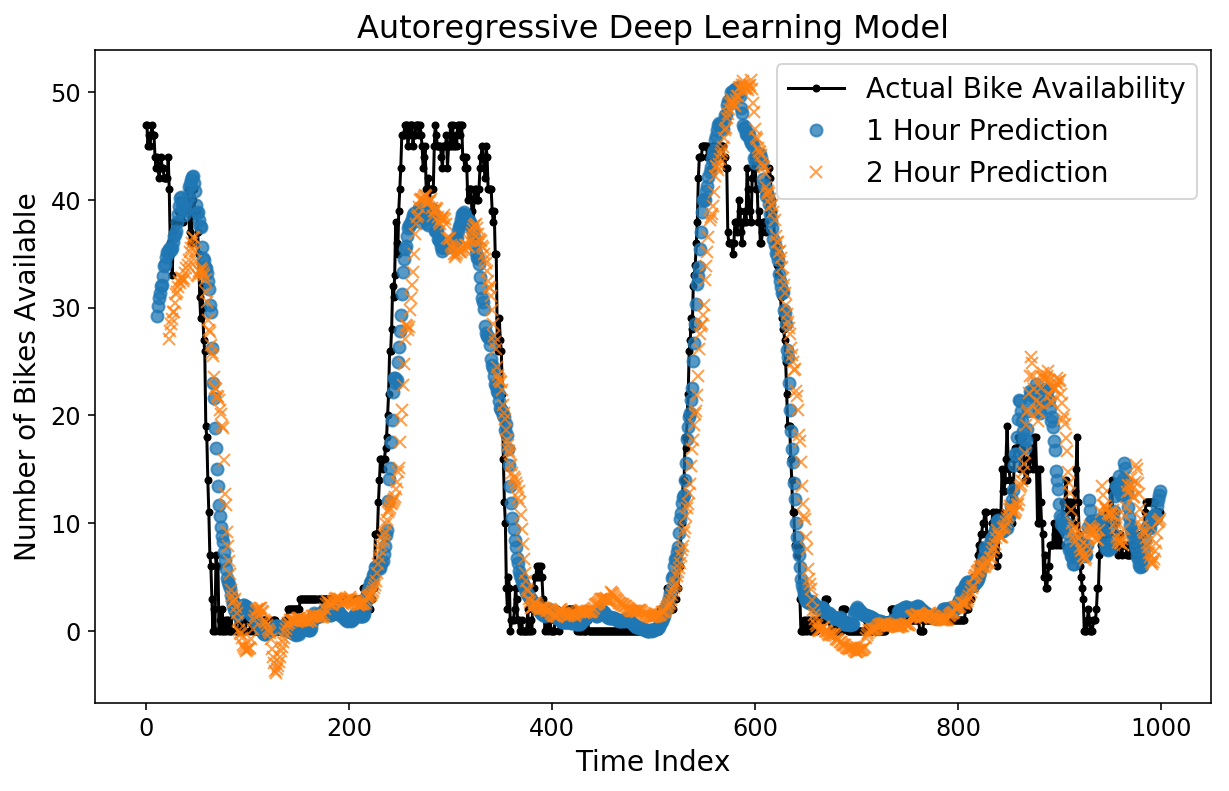

In [104]:
plt.figure();
plt.plot(y[-test_size:], 'k.-');
plt.plot(np.arange(11, test_size),  dl_prediction[:-11, 11], 'o', alpha=0.75);
plt.plot(np.arange(23, test_size), dl_prediction[:-23, 23], 'x', alpha=0.75);
plt.legend(['Actual Bike Availability', 
            '1 Hour Prediction', 
            '2 Hour Prediction']);
plt.ylabel('Number of Bikes Available');
plt.xlabel('Time Index');
plt.title('Autoregressive Deep Learning Model');

The predictions look fairly decent by eye. Let's check out the MAE.

In [105]:
y_actual = dl_pipeline.transform_y(X)
dl_mae = mean_absolute_error(y_actual[-test_size:], 
                             dl_prediction,
                             multioutput='raw_values')

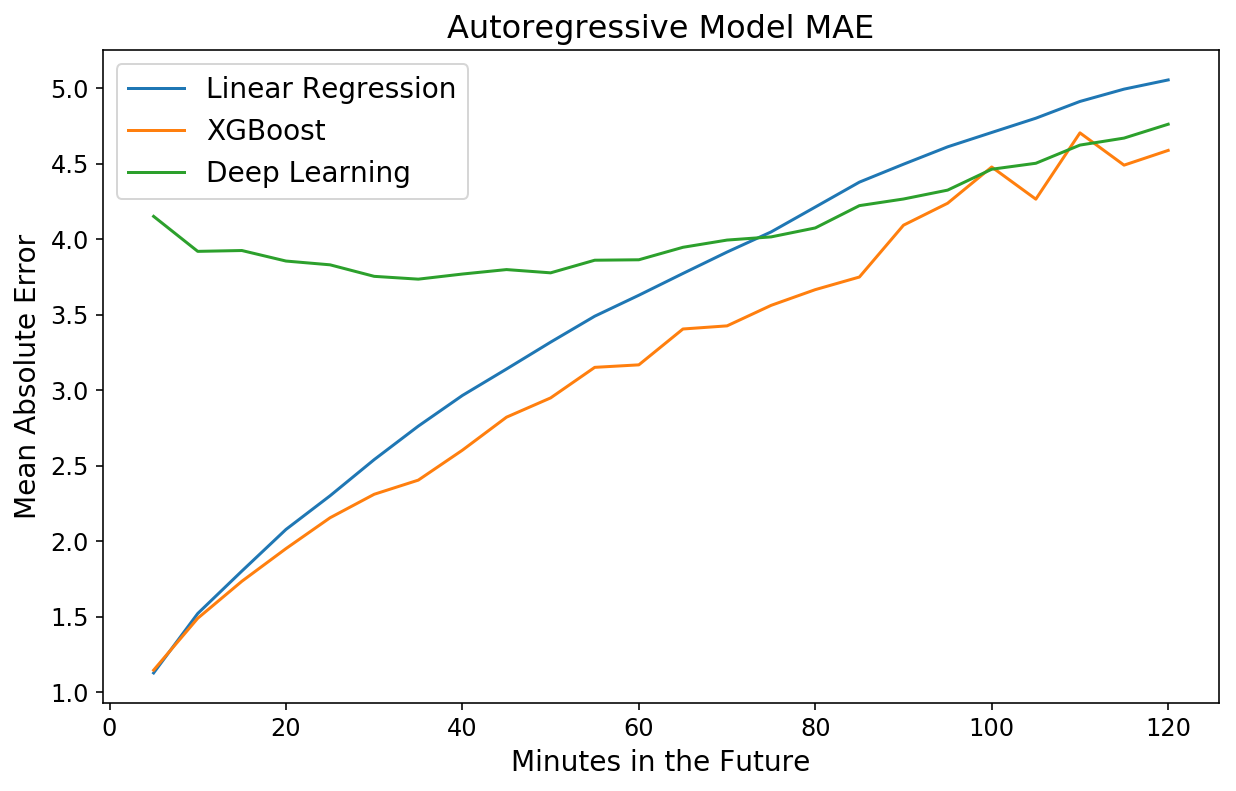

In [106]:
y_actual = dl_pipeline.transform_y(X)
dl_mae = mean_absolute_error(y_actual[-test_size:], dl_prediction,
                              multioutput='raw_values')
plt.plot(np.arange(1, 25) * 5, lin_mae);
plt.plot(np.arange(1, 25) * 5, xgb_mae);
plt.plot(np.arange(1, 25) * 5, dl_mae[:24])
plt.xlabel('Minutes in the Future');
plt.ylabel('Mean Absolute Error');
plt.title('Autoregressive Model MAE');
plt.legend(['Linear Regression', 
            'XGBoost',
            'Deep Learning']);

Strangely, the model is worse for times close in the future but roughly on par with XGBoost for 2-hour predictions. This is yet another example of the power and ease of XGBoost.

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">I continue to be astounded by how 1) fast and 2) robust to overfitting XGBoost is. My favorite machine learning library by a long shot.</p>&mdash; Sean J. Taylor (@seanjtaylor) <a href="https://twitter.com/seanjtaylor/status/837081497857310720?ref_src=twsrc%5Etfw">March 1, 2017</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

## Takeaways

In this post, I showed how to use the [skits](https://github.com/ethanrosenthal/skits) library to train a supervised learning model to directly predict a time series _horizon_. We then easily ramped up the complexity of our models by simply slotting more complex models into our scikit-learn pipeline. At best, we were able to forecast the number of bikes at the bike share station by my apartment to within 4.5 bikes 2 hours in advance.

I should note that this post was not a fully scientific study. To do that, I should have created training, validation, and test data sets. As well, I should have run a proper hyperparameter search (especially for the deep learning model!). Nevertheless, I'm still confident that we can do a decent job at horizon prediction.

How can we do a better job? There are a number of ways, which I would like to explore in further blog posts. Instead of thinking of our bike availibility data as a continuous time series to predict, we could go with an approach similar to [ordinal regression]({{< ref "/blog/spacecutter-ordinal-regression" >}}). Additionally, we can incorporate information from other bike stations to better predict our particular station. Stay tuned!